In [4]:
import config as config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
import seaborn as seabornInstance 
from datetime import date, timedelta, datetime
from operator import itemgetter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
import plotly.graph_objects as go
from pandas_datareader import data as pdr
import glob

#yahoo finance and pandadata reader override
import yfinance as yf
yf.pdr_override()

#machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn import metrics

**This notebook analyzes the new's score and prices movements of a few stocks combined; to provide more data points to train and test**

In [7]:
#import all dataset
path = '/Users/Erik/Desktop/DataScience/SentimentAnalysis/data'
all_files = glob.glob(path + '/*.csv')

data = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    data.append(df)

price_score_df = pd.concat(data, axis=0, ignore_index=True)
price_score_df.describe()

,t_neg,t_neu,t_pos,t_compound,d_neg,d_neu,d_pos,d_compound,t_neg_pc,Open,High,Low,Close,Adj Close,Volume,Adj Close PC
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,152.000000,113.000000,113.000000,113.000000,113.000000,113.000000,1.130000e+02,107.000000
mean,0.058049,0.838392,0.103496,0.081808,0.041112,0.852449,0.100115,0.221562,inf,510.349514,525.464682,497.665292,512.479201,512.466197,1.907987e+07,-0.012768
std,0.037860,0.059444,0.064012,0.136571,0.020044,0.044399,0.040576,0.171440,NaN,620.939578,636.512305,609.448247,623.974550,623.981268,2.578324e+07,0.058998
min,0.000000,0.526000,0.000000,-0.510600,0.000000,0.663200,0.000000,-0.548200,-1.000000,98.000000,103.690002,95.000000,99.080002,99.080002,2.340300e+06,-0.175518
25%,0.036030,0.816126,0.076944,0.017794,0.029844,0.836077,0.082017,0.151928,-0.274208,165.289993,172.550003,157.110001,171.130005,171.130005,3.716800e+06,-0.051845
50%,0.055947,0.836500,0.099020,0.081536,0.041768,0.853980,0.094000,0.215704,0.064378,239.770004,250.000000,237.119995,242.210007,242.210007,8.396500e+06,-0.019545
75%,0.073689,0.863000,0.122450,0.134627,0.050880,0.872410,0.113635,0.286752,0.402891,445.000000,463.309998,420.630005,450.339996,450.339996,1.753660e+07,0.034871
max,0.268000,1.000000,0.474000,0.659700,0.145000,1.000000,0.302500,0.915300,inf,2026.420044,2039.300049,1987.969971,2009.290039,2009.290039,1.067212e+08,0.119808


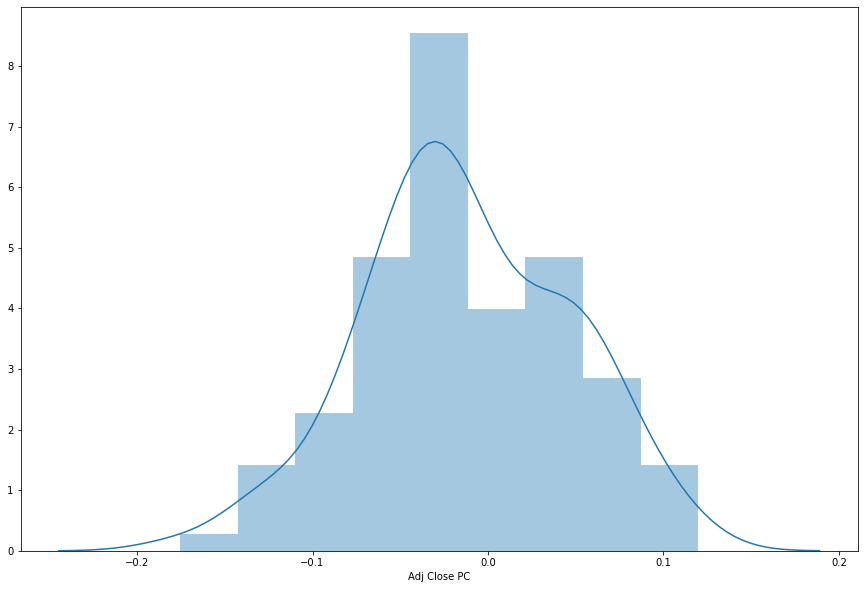

In [8]:
#check average of daily closing
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(price_score_df['Adj Close PC'])

**Predict Today's Closing Price based on Today's news score**

In [12]:
#adding weekday to df
price_score_df['publishedAt'] = pd.to_datetime(price_score_df['publishedAt'])
price_score_df['day_of_week'] = price_score_df['publishedAt'].dt.day_name()

#remove weekend values and NaN values
ps_weekday_only_df = pd.DataFrame(price_score_df.dropna())

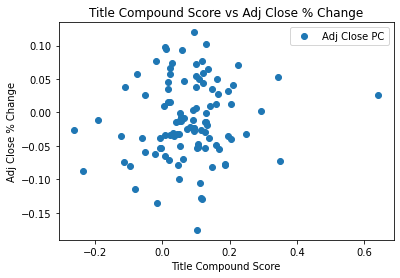

In [13]:
#plot scatter plot using Title Compound Score and Adj Close % Change
ps_weekday_only_df.plot(x='t_compound', y='Adj Close PC', style='o')
plt.title('Title Compound Score vs Adj Close % Change')
plt.xlabel('Title Compound Score')
plt.ylabel('Adj Close % Change')
plt.show()

y-intercept: [-0.01797839]
coef: [[0.04605948]]


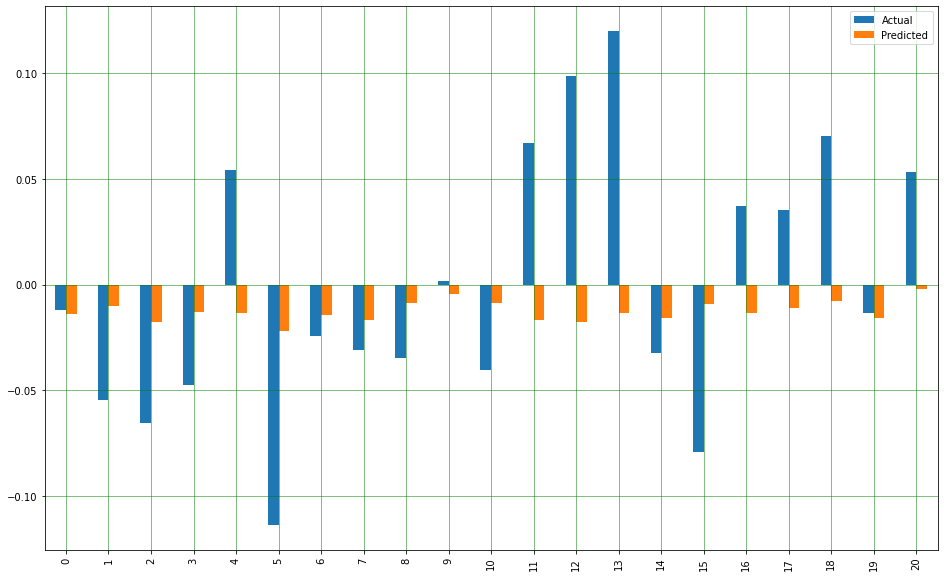

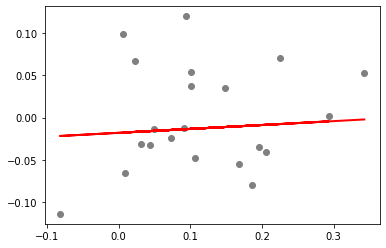

Root Mean Squared Error: 0.06086449559939646
SD in actual y test set:  0.06029554196996529
RMSE over SD of Actual y test:  1.0094360811901248


In [14]:
def single_regression():
    #define independant and dependant variables
    X = ps_weekday_only_df['t_compound'].values.reshape(-1, 1)
    y = ps_weekday_only_df['Adj Close PC'].values.reshape(-1, 1)

    #split, test, train - 80% for training, 20% for test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    #train the data
    regressor = LinearRegression(fit_intercept=True)
    regressor.fit(X_train, y_train)

    #to retrieve the y-intercept
    print('y-intercept: ' + str(regressor.intercept_))

    #to retrive the slope
    print('coef: ' + str(regressor.coef_))

    #predict y, Adj Close
    y_pred = regressor.predict(X_test)

    #compare the Real output in X_test with predicted value
    pred_rs1 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

    #visualize the comparison
    pred_rs1.plot(kind='bar', figsize=(16, 10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')

    plt.show()

    #plot regression line, predicted regression line against test value
    plt.scatter(X_test, y_test, color='gray')
    plt.plot(X_test, y_pred, color='red', linewidth=2)
    plt.show()

    #valuation metrics
    rmse_y_pred = metrics.mean_squared_error(y_test, y_pred, squared=False)
    print('Root Mean Squared Error:', rmse_y_pred)

    #compare RMSE with Standard Deviation of the actual y in test dataset
    print('SD in actual y test set: ', y_test.std())

    print('RMSE over SD of Actual y test: ', rmse_y_pred/y_test.std())

single_regression()

**Using Multiple Linear Regression**

coef: [[  0.23422885   0.07394464 -62.38586274 -63.01540237 -63.28557739]]


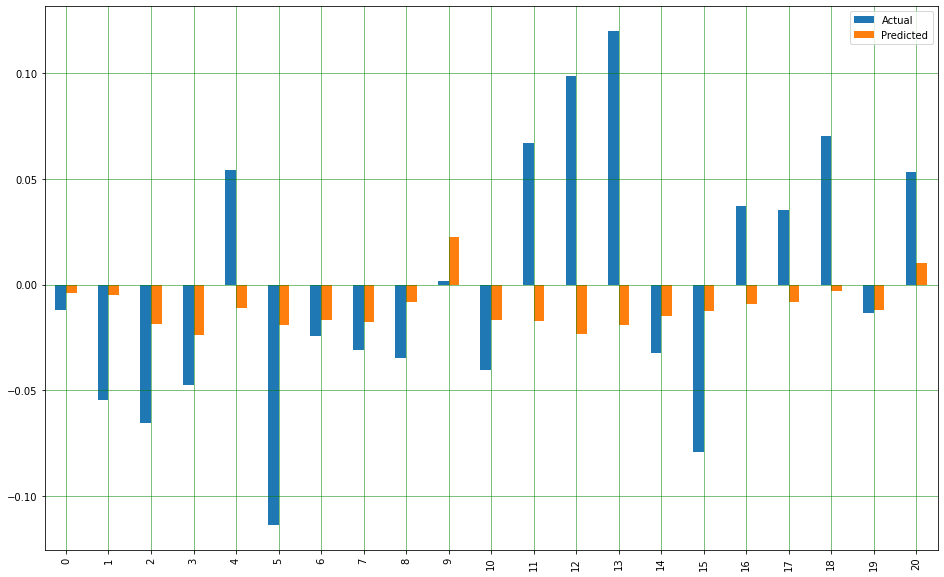

Root Mean Squared Error: 0.06083398560624299
SD in actual y test set:  0.06029554196996529
RMSE over SD of Actual y test:  1.0089300737448537


In [15]:
def multi_regression():
    #define independant and dependant variables
    X = ps_weekday_only_df[['t_compound', 'd_compound', 't_neg', 't_neu', 't_pos']]
    y = ps_weekday_only_df['Adj Close PC'].values.reshape(-1, 1)

    #split, test, train - 80% for training, 20% for test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    #train the data
    regressor = LinearRegression(fit_intercept=True)
    regressor.fit(X_train, y_train)

    #to retrive the slope
    print('coef: ' + str(regressor.coef_))

    #predict y, Adj Close
    y_pred = regressor.predict(X_test)


    #compare the Real output in X_test with predicted value
    pred_rs1 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

    #visualize the comparison
    pred_rs1.plot(kind='bar', figsize=(16, 10))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')

    plt.show()
    
    #valuation metrics
    rmse_y_pred = metrics.mean_squared_error(y_test, y_pred, squared=False)
    print('Root Mean Squared Error:', rmse_y_pred)

    #compare RMSE with Standard Deviation of the actual y in test dataset
    print('SD in actual y test set: ', y_test.std())

    print('RMSE over SD of Actual y test: ', rmse_y_pred/y_test.std())

multi_regression()